In [1]:
!pip uninstall -y ultralytics
!pip install ultralytics==8.0.196
!pip install ultralytics -U


Found existing installation: ultralytics 8.0.196
Uninstalling ultralytics-8.0.196:
  Successfully uninstalled ultralytics-8.0.196
Defaulting to user installation because normal site-packages is not writeable
  Using cached ultralytics-8.0.196-py3-none-any.whl.metadata (31 kB)
Using cached ultralytics-8.0.196-py3-none-any.whl (631 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached ultralytics-8.4.18-py3-none-any.whl.metadata (39 kB)
Using cached ultralytics-8.4.18-py3-none-any.whl (1.2 MB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.196
    Uninstalling ultralytics-8.0.196:
      Successfully uninstalled ultralytics-8.0.196


In [2]:
import os
# Si tu notebook está dentro de la carpeta 'notebooks', esto sube un nivel.
# Si lo ejecutas dos veces por error, subirá dos niveles, así que ten cuidado.
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Directorio actual: {os.getcwd()}")

Directorio actual: /home/aleixbertranandreu/Documents/HackUDC_2026


🚀 Arrancando el Escáner Visual en: cuda
⏳ Cargando el cerebro de la IA (OWL-ViT)...


The image processor of type `OwlViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/412 [00:00<?, ?it/s]

OwlViTForObjectDetection LOAD REPORT from: google/owlvit-base-patch32
Key                                         | Status     |  | 
--------------------------------------------+------------+--+-
owlvit.vision_model.embeddings.position_ids | UNEXPECTED |  | 
owlvit.text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🔍 Escaneando la foto en busca de: ['upper clothing', 'pants', 'skirt', 'dress', 'bag', 'shoes']

📝 REPORTE DE LA IA:
 ✅ ¡ZAS! He visto: SKIRT con un 18.2% de seguridad.


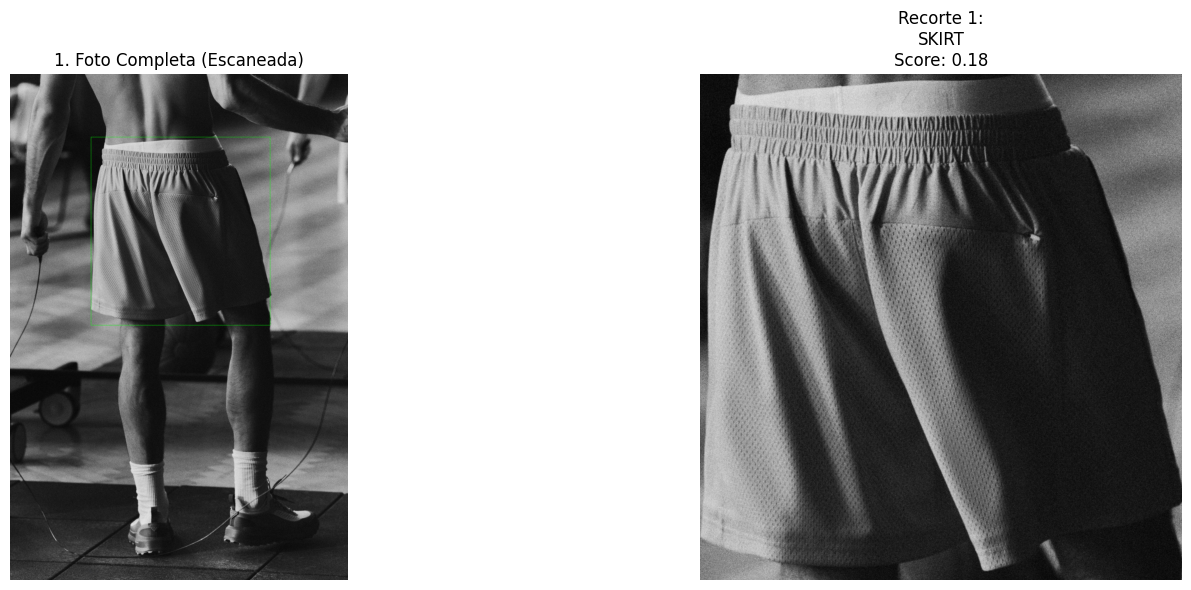

In [4]:
import torch
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# --- 1. CONFIGURACIÓN ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Arrancando el Escáner Visual en: {device}")

print("⏳ Cargando el cerebro de la IA (OWL-ViT)...")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

# ⚠️ PON AQUÍ TU FOTO DE PRUEBA
ruta_foto = "../data/images/bundles/B_00efaa88351d.jpg" 

# Truco por si la ruta de Jupyter se lía
if not os.path.exists(ruta_foto):
    ruta_foto = "data/images/bundles/B_00efaa88351d.jpg"

try:
    imagen_original = Image.open(ruta_foto).convert("RGB")
    
    # ¿Qué le decimos a la IA que busque en texto libre?
    etiquetas = [["upper clothing", "pants", "skirt", "dress", "bag", "shoes"]]
    print(f"🔍 Escaneando la foto en busca de: {etiquetas[0]}")

    # --- 2. LA MAGIA DE DETECCIÓN ---
    inputs = processor(text=etiquetas, images=imagen_original, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Ajustamos las cajas al tamaño real de tu foto
    target_sizes = torch.tensor([imagen_original.size[::-1]])
    # Threshold de 0.1 para que sea un poco flexible
    results = processor.post_process_grounded_object_detection(
        outputs=outputs, target_sizes=target_sizes, text_labels=etiquetas, threshold=0.1
    )[0]

    # --- 3. DIBUJAR Y RECORTAR ---
    imagen_anotada = imagen_original.copy()
    draw = ImageDraw.Draw(imagen_anotada)
    recortes = []
    titulos = []

    print("\n📝 REPORTE DE LA IA:")
    for caja, score, label_idx in zip(results["boxes"], results["scores"], results["labels"]):
        x1, y1, x2, y2 = map(int, caja.tolist())
        nombre_prenda = etiquetas[0][label_idx.item()]
        confianza = score.item()
        
        print(f" ✅ ¡ZAS! He visto: {nombre_prenda.upper()} con un {confianza*100:.1f}% de seguridad.")
        
        # Dibujamos un rectángulo verde fluorescente para verlo bien
        draw.rectangle([x1, y1, x2, y2], outline="lime", width=4)
        
        # Guardamos el recorte
        recorte = imagen_original.crop((x1, y1, x2, y2))
        recortes.append(recorte)
        titulos.append(f"{nombre_prenda.upper()}\nScore: {confianza:.2f}")

    # --- 4. MOSTRAR EL SHOW POR PANTALLA ---
    if len(recortes) > 0:
        fig, axs = plt.subplots(1, len(recortes) + 1, figsize=(18, 6))
        
        axs[0].imshow(imagen_anotada)
        axs[0].set_title("1. Foto Completa (Escaneada)")
        axs[0].axis('off')
        
        for i, (recorte, titulo) in enumerate(zip(recortes, titulos)):
            axs[i+1].imshow(recorte)
            axs[i+1].set_title(f"Recorte {i+1}:\n{titulo}")
            axs[i+1].axis('off')
            
        plt.tight_layout()
        plt.show()
    else:
        print("🤷‍♂️ La IA ha mirado la foto pero no está segura de ver ninguna de esas prendas.")

except Exception as e:
    print(f"❌ Error al abrir la imagen o procesar: {e}")

In [ ]:
import torch
import os
from PIL import Image
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from tqdm import tqdm

# --- 1. CONFIGURACIÓN ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Iniciando el Scrapper de Recortes en: {device}")

# 🔥 QUiTAMOS LOS ../ PORQUE ESTÁS EN LA RAÍZ DEL PROYECTO 🔥
CARPETA_ORIGEN = "data/images/bundles/"
CARPETA_DESTINO = "data/recortes_entrenamiento/"

for subcarpeta in ["arriba", "abajo", "cuerpo_entero", "otros"]:
    os.makedirs(os.path.join(CARPETA_DESTINO, subcarpeta), exist_ok=True)

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

# Vamos a probar solo con las primeras 20 fotos para no perder tiempo
archivos = [f for f in os.listdir(CARPETA_ORIGEN) if f.endswith('.jpg')][:20]

# Simplificamos las etiquetas para que no se líe entre falda y pantalón
etiquetas = [["upper clothing", "lower clothing", "dress"]]

print(f"🔪 Empezando a scrappear {len(archivos)} imágenes...")

# --- 2. EL BUCLE SCRAPPER ---
for archivo in tqdm(archivos):
    ruta_foto = os.path.join(CARPETA_ORIGEN, archivo)
    bundle_id = archivo.replace(".jpg", "")
    
    try:
        imagen = Image.open(ruta_foto).convert("RGB")
        inputs = processor(text=etiquetas, images=imagen, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([imagen.size[::-1]])
        results = processor.post_process_grounded_object_detection(
            outputs=outputs, target_sizes=target_sizes, text_labels=etiquetas, threshold=0.1
        )[0]

        # --- 3. GUARDAR LOS RECORTES ---
        for i, (caja, score, label_idx) in enumerate(zip(results["boxes"], results["scores"], results["labels"])):
            confianza = score.item()
            if confianza > 0.1: # Si está un poco seguro
                nombre_prenda = etiquetas[0][label_idx.item()]
                x1, y1, x2, y2 = map(int, caja.tolist())
                
                # Recortamos la imagen
                recorte = imagen.crop((x1, y1, x2, y2))
                
                # Decidimos en qué carpeta lo guardamos
                if nombre_prenda == "upper clothing":
                    carpeta_final = "arriba"
                elif nombre_prenda == "lower clothing": # Aquí entran faldas y pantalones juntos
                    carpeta_final = "abajo"
                elif nombre_prenda == "dress":
                    carpeta_final = "cuerpo_entero"
                else:
                    carpeta_final = "otros"
                
                # Guardamos el archivo con el ID original para no perder el rastro
                nombre_archivo_salida = f"{bundle_id}_{carpeta_final}_{i}.jpg"
                ruta_salida = os.path.join(CARPETA_DESTINO, carpeta_final, nombre_archivo_salida)
                
                recorte.save(ruta_salida)
                
    except Exception as e:
        print(f"❌ Error con la imagen {archivo}: {e}")

print("\n🎉 ¡Scrapeo terminado! Revisa la carpeta 'data/recortes_entrenamiento/'")

🚀 Iniciando el Scrapper de Recortes en: cuda


Loading weights:   0%|          | 0/412 [00:00<?, ?it/s]

OwlViTForObjectDetection LOAD REPORT from: google/owlvit-base-patch32
Key                                         | Status     |  | 
--------------------------------------------+------------+--+-
owlvit.vision_model.embeddings.position_ids | UNEXPECTED |  | 
owlvit.text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🔪 Empezando a scrappear 20 imágenes...


100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


🎉 ¡Scrapeo terminado! Revisa la carpeta 'data/recortes_entrenamiento/'


: 